In [ ]:
import pickle
import pandas as pd
import numpy as np

# Load
with open("data/biomass_sample_data_reps_separate.pkl", "rb") as f:
    df_loaded = pickle.load(f)

# scale digital_biomass from mm³ to millions (for easier plotting/metrics)
df_loaded["digital_biomass"] = df_loaded["digital_biomass"] / 1e6

df_loaded.head()

,days_of_phenotyping,species,nitrogen_applied,drought_stress,rep,mean_plant_temperature,median_plant_temperature,std_plant_temperature,min_plant_temperature,max_plant_temperature,mean_side_area,mean_top_area,digital_biomass
0,1,barley_1,25,0,1,24.447787,24.424066,0.902963,21.906194,27.958105,29357.909527,35079.04116,5.498560
1,2,barley_1,25,0,1,24.451300,24.475998,0.958762,21.744783,27.867776,29545.947366,35168.96481,5.540867
2,3,barley_1,25,0,1,24.532748,24.573843,0.989323,21.557134,27.984342,29512.180481,37351.67743,5.703696
3,4,barley_1,25,0,1,24.434585,24.451585,0.945582,21.674772,27.894140,29254.245671,38200.53196,5.717730
4,5,barley_1,25,0,1,24.432615,24.442659,0.945267,21.747331,28.126928,28722.438850,39499.22940,5.708416


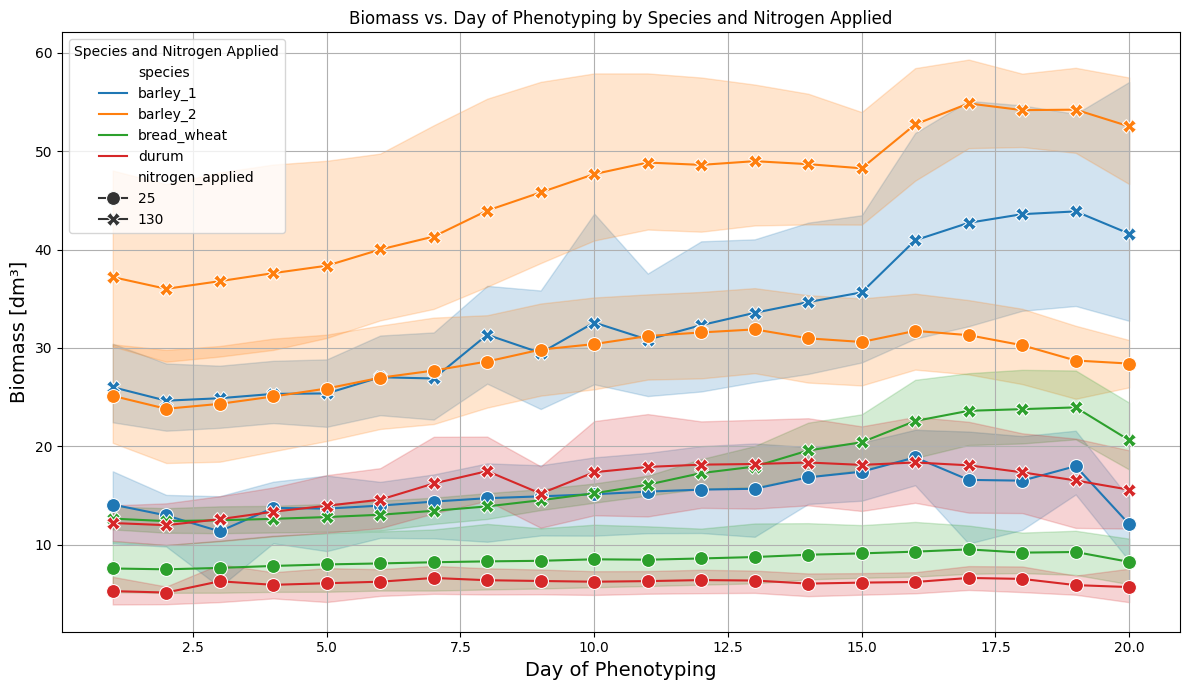

In [ ]:
# %% Plot digital biomass of each cultivar over days of phenotyping
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_loaded,
    x="days_of_phenotyping",
    y="digital_biomass",
    hue="species",
    style="nitrogen_applied",
    markers=True,
    markersize=10,
    dashes=False,
)
plt.title("Biomass vs. Day of Phenotyping by Species and Nitrogen Applied")
plt.xlabel("Day of Phenotyping", fontsize=14)
plt.ylabel("Biomass [dm³]", fontsize=14)
plt.legend(title="Species and Nitrogen Applied")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Build ML Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold

# ----------------------
# Define Features/Target
# ----------------------
feature_cols = [
    "days_of_phenotyping",
    "species",
    "nitrogen_applied",
    "drought_stress",
    # "mean_plant_temperature",
    # "std_plant_temperature",
    # "median_plant_temperature",
    # "min_plant_temperature",
    # "max_plant_temperature",
]
target_col = "digital_biomass"

X_data_init = df_loaded[feature_cols]
y_data_init = df_loaded[target_col]

# -----------------------
# Define Column Groups
# -----------------------
poly_features = ["days_of_phenotyping"]
categorical_features = ["species"]
numeric_features = [
    "days_of_phenotyping",
    "nitrogen_applied",
    "drought_stress",
    # "mean_plant_temperature",
    # "std_plant_temperature",
    # "median_plant_temperature",
    # "min_plant_temperature",
    # "max_plant_temperature",
]

# --------------------------
# Build Preprocessing Pipeline
# --------------------------
preprocessor = ColumnTransformer(
    [
        # ("poly_day", PolynomialFeatures(degree=3, include_bias=False), poly_features),
        (
            "onehot_species",
            Pipeline(
                [
                    ("onehot", OneHotEncoder(drop="first")),
                    ("scaler", StandardScaler(with_mean=False)),  # Important: with_mean=False for sparse data
                ]
            ),
            categorical_features,
        ),
        ("num", StandardScaler(), numeric_features),
    ]
)

# --------------------------
# Train/Test Split
# --------------------------
# Create a stratification key combining species and nitrogen
df_loaded["strata"] = df_loaded["species"].astype(str) + "_" + df_loaded["nitrogen_applied"].astype(str) + "_"+ df_loaded["drought_stress"].astype(str)
strata = df_loaded["strata"]

X_train, X_test, y_train, y_test = train_test_split(
    X_data_init, y_data_init, test_size=0.3, random_state=42  #  , stratify=strata
)

df_train = X_train.copy()
df_train[target_col] = y_train

_ = preprocessor.fit_transform(X_data_init)  # Fit preprocessor on entire data

Linear Regression Regression
Best parameters: {}
Test R² score (best model, original scale): 0.758
Test MAE (best model, original scale): 5.108e+00
Test MSE (best model, original scale): 5.381e+01
Test RMSE (best model, original scale): 7.336e+00
CV R² mean ± std (scaled y): 0.772 ± 0.024


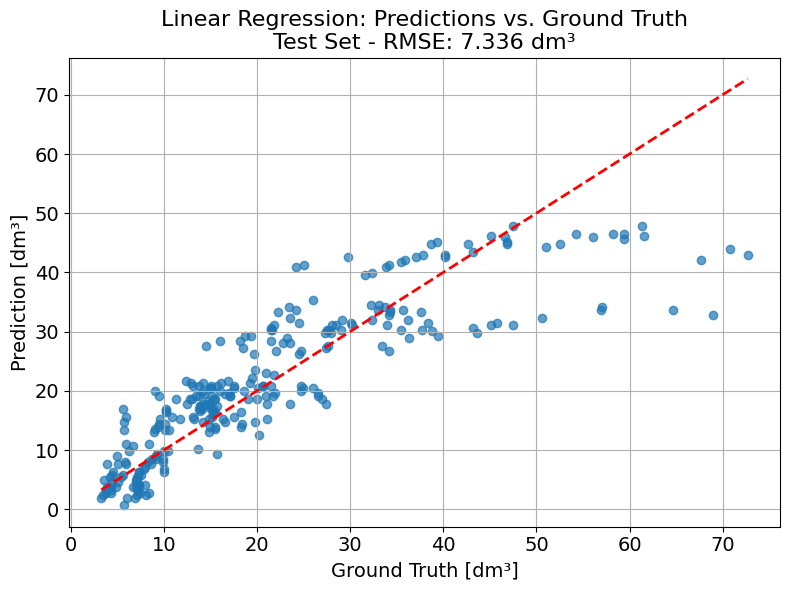

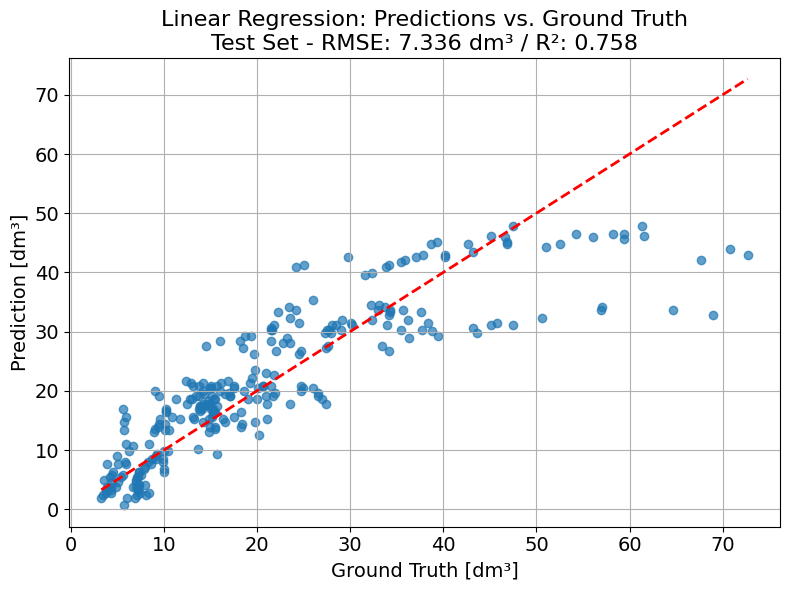

In [37]:
# --------------------------
# Full Pipeline: Preprocessing + Model
# --------------------------

# Choose either Ridge or Lasso
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# "Polyn. Regression" # "Ridge"  #  "Lasso" --- IGNORE ---
model_name = "Linear Regression"
model = LinearRegression()

# model_name = "Polyn. Regression"

# model_name = "MLP Regression" 
# model = MLPRegressor(
#     hidden_layer_sizes=(100, 50,),
#     activation="relu",
#     solver="adam",
#     # alpha=0.1,
#     learning_rate="adaptive",
#     max_iter=2000,
#     # tol=1e-4,
#     early_stopping=False,
#     # validation_fraction=0.1,
#     n_iter_no_change=20,
#     random_state=42,
# )
pipeline = Pipeline([("preprocess", preprocessor), ("regressor", model)])



param_grid = {} # {"regressor__hidden_layer_sizes": [(100, 50, 25), (50, 25), (100, 50), (100,), (50,), (20, 10, 5)]} # Ridge # param_grid = {"regressor__alpha": np.arange(0, 3, 0.05)}  # ridge regularization strength
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring="r2")

# %%
# --------------------------
# 6b. Scale target variable (y)
# --------------------------
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# --------------------------
# 7. Fit Model
# --------------------------
grid.fit(X_train, y_train_scaled)

# --------------------------
# 8. Evaluate
# --------------------------

best_model = grid.best_estimator_.named_steps["regressor"]
# Predict scaled targets on test set
y_pred_scaled = grid.predict(X_test)

# Inverse transform predictions back to original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Compute R² score on original scale
from sklearn.metrics import r2_score

print(f"{model_name} Regression")
print(f"Best parameters: {grid.best_params_}")
r2_test_ridge = r2_score(y_test, y_pred)
mae_test_ridge = np.mean(np.abs(y_test - y_pred))
mse_test_ridge = np.mean((y_test - y_pred) ** 2)
rmse_test_ridge = np.sqrt(mse_test_ridge)
print(f"Test R² score (best model, original scale): {r2_test_ridge:.3f}")
print(f"Test MAE (best model, original scale): {mae_test_ridge:.3e}")
print(f"Test MSE (best model, original scale): {mse_test_ridge:.3e}")
print(f"Test RMSE (best model, original scale): {rmse_test_ridge:.3e}")

# Optional: Cross-validation scoring on scaled y
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor

cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train_scaled, cv=5, scoring="r2", n_jobs=-1)
print(f"CV R² mean ± std (scaled y): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

title_font_size = 16
axis_font_size = 14

# Plot predictions vs ground truth (simple)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Ground Truth [dm³]", fontsize=axis_font_size)
plt.ylabel("Prediction [dm³]", fontsize=axis_font_size)
plt.title(f"{model_name}: Predictions vs. Ground Truth\nTest Set - RMSE: {rmse_test_ridge:.3f} dm³", fontsize=title_font_size)
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot predictions vs ground truth (with R²)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Ground Truth [dm³]", fontsize=axis_font_size)
plt.ylabel("Prediction [dm³]", fontsize=axis_font_size)
plt.title(f"{model_name}: Predictions vs. Ground Truth\nTest Set - RMSE: {rmse_test_ridge:.3f} dm³ / R²: {r2_test_ridge:.3f}", fontsize=title_font_size)
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)
plt.grid(True)
plt.tight_layout()
plt.show()

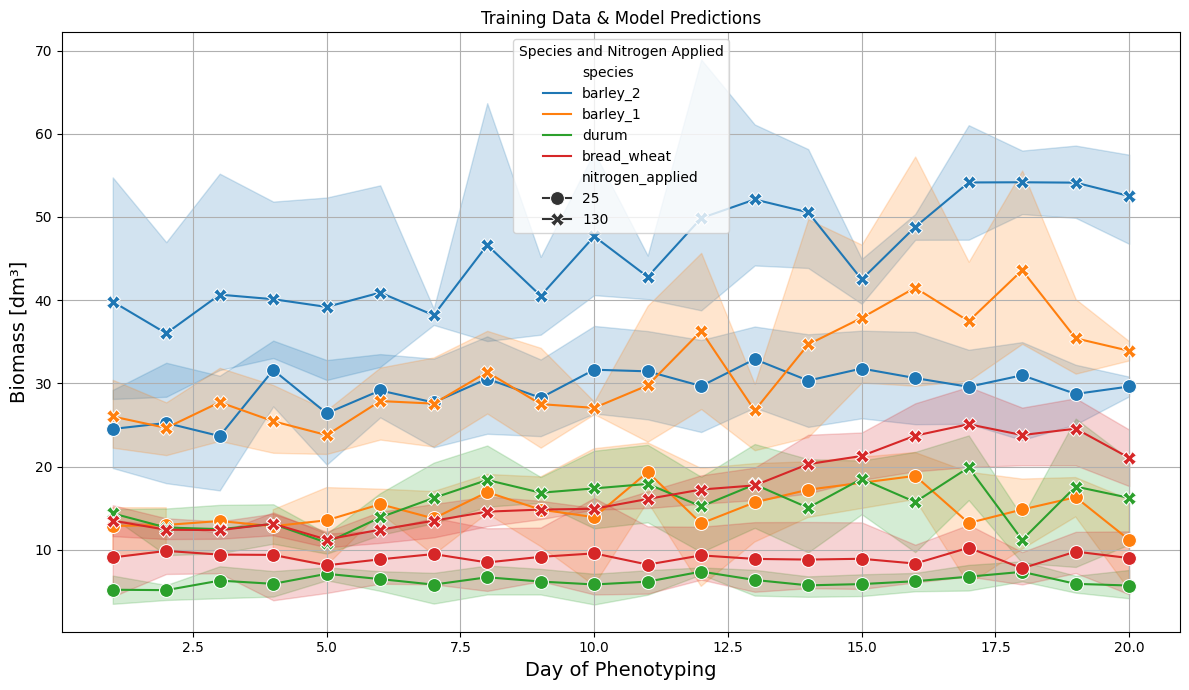

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_train_data_with_sns_lineplot_and_overlay_model_predictions(
    df_train_data,
    y_train_pred,
    model_name,
):
    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=df_train_data,
        # data=df_loaded[(df_loaded["species"] == "barley_1") & (df_loaded["nitrogen_applied"] == 130)],
        x="days_of_phenotyping",
        y="digital_biomass",
        hue="species",
        style="nitrogen_applied",
        markers=True,
        markersize=10,
        dashes=False,
    )
    plt.title("Training Data & Model Predictions")
    plt.xlabel("Day of Phenotyping", fontsize=14)
    plt.ylabel("Biomass [dm³]", fontsize=14)
    plt.legend(title="Species and Nitrogen Applied")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

y_train_scaled_pred = grid.predict(X_train)
y_train_pred = y_scaler.inverse_transform(y_train_scaled_pred.reshape(-1, 1)).ravel()

plot_train_data_with_sns_lineplot_and_overlay_model_predictions(
    df_train,
    y_train_pred,
    model_name,
)

In [39]:
# %% Investigate model predictions over days for different nitrogen levels
def plot_model_predictions_over_days(
    test_days,
    test_species,
    test_drought_stress,
    test_nitrogen_levels,
    preprocessor,
    y_scaler,
    model,
    model_name,
    integrated_data,
    ax=None,
):
    """
    Plot integrated_data (with seaborn lineplot showing confidence intervals)
    and overlay model predictions for a given species / drought condition
    across multiple nitrogen levels.

    - integrated_data: full dataframe with columns ['days_of_phenotyping','digital_biomass',
      'species','nitrogen_applied','drought_stress', ...]
    - preprocessor: fitted ColumnTransformer / pipeline preprocessing step
    - model: fitted regressor that accepts preprocessor.transform(...) output
    - y_scaler: fitted StandardScaler for target (to inverse-transform preds)
    """
    title_font_size = 16
    axis_font_size = 14

    show_plt = False
    if ax is None:
        show_plt = True
        fig, ax = plt.subplots(figsize=(7, 6))

    # Filter integrated_data to same drought condition so CI / lines are comparable
    data_plot = integrated_data[
        (integrated_data["species"] == test_species)
        & (integrated_data["drought_stress"] == test_drought_stress)
        & (integrated_data["nitrogen_applied"].isin(test_nitrogen_levels))
        ].copy()

    # Colors/linestyles for prediction overlays (distinct and visible)
    # pred_colors = ["#000000", "#FF7F0E", "#1F77B4", "#2CA02C"]
    # pred_linestyles = ["-"] #, "--", "-.", ":"]
    for idx, n_val in enumerate(test_nitrogen_levels):
        test_df = pd.DataFrame(
            {
                "days_of_phenotyping": test_days,
                "species": [test_species] * len(test_days),
                "nitrogen_applied": [n_val] * len(test_days),
                "drought_stress": [test_drought_stress] * len(test_days),
            }
        )
        # seaborn lineplot: show confidence intervals, hue by species and style by nitrogen_applied
        # (use estimator='mean' so CI is shown around the mean curve)
        

        # Preprocess and predict
        Xp = preprocessor.transform(test_df)
        pred_scaled = model.predict(Xp)
        pred = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

        # Plot predictions
        ax.plot(
            test_days,
            pred,
            label=f"Prediction (N={n_val})",
            marker="o" if n_val == 25 else "x",
            markeredgewidth=2,
            markersize=7,
            linewidth=2,
            alpha=0.9,
            linestyle=":",
        )

        # Plot ground truth points for this nitrogen level
        gt = data_plot[data_plot["nitrogen_applied"] == n_val].sort_values("days_of_phenotyping")
        if not gt.empty:
            sns.lineplot(
                data=gt,# data_plot[data_plot["nitrogen_applied"] == n_val],
                x="days_of_phenotyping",
                y="digital_biomass",
                # hue="species",
                # style="nitrogen_applied",
                ax=ax,
                markers=True,
                markersize=10,
                dashes=False,
                # palette="tab10",
                # linewidth=2,
                # alpha=0.7,
                # label=f"GT (N = {n_val})",
                label=f"Ground Truth (N={n_val})"
            )

            # ax.plot(
            # gt["days_of_phenotyping"],
            # gt["digital_biomass"],
            # label=f"Ground Truth (N={n_val})",
            # marker="o" if n_val == 25 else "x",
            # markeredgewidth=2,
            # markersize=7,
            # linewidth=2,
            # alpha=0.9,
            # )

        # Title and labels
        species_name_map = {"barley_2": "Barley v2", "durum": "Durum Wheat", "barley_1": "Barley v1", "bread_wheat": "Bread Wheat"}
        species_label = species_name_map.get(test_species, test_species)
        cond_label = "Drought" if test_drought_stress else "No Drought"
        ax.set_xlabel("Days of Phenotyping", fontsize=axis_font_size)
        ax.set_ylabel("Biomass (dm³)", fontsize=axis_font_size)
        ax.set_title(f"{model_name} - {species_label} - {cond_label}", fontsize=title_font_size)
        ax.grid(True)
        # adjust tick label size and legend font to match axis sizing (with sensible minimums)
        ax.tick_params(axis="both", labelsize=max(8, axis_font_size - 2))
        ax.legend(loc="upper left", fontsize=max(8, axis_font_size - 4))

    if show_plt:
        plt.tight_layout()
        plt.show()

    return ax

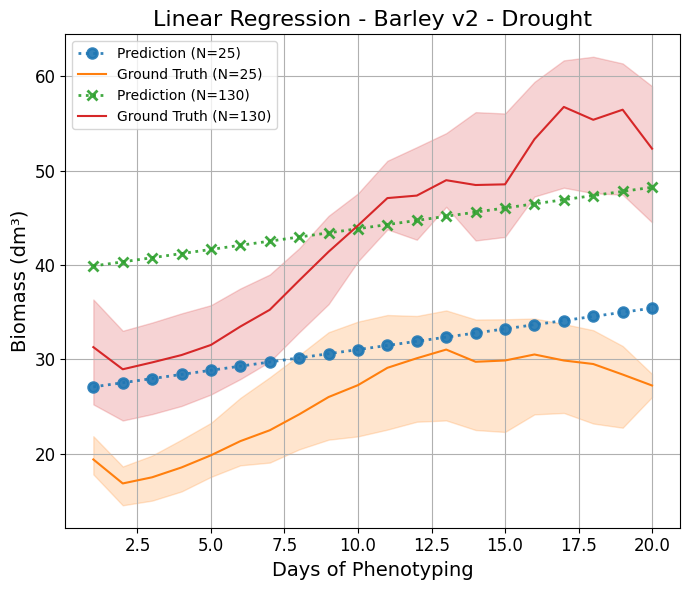

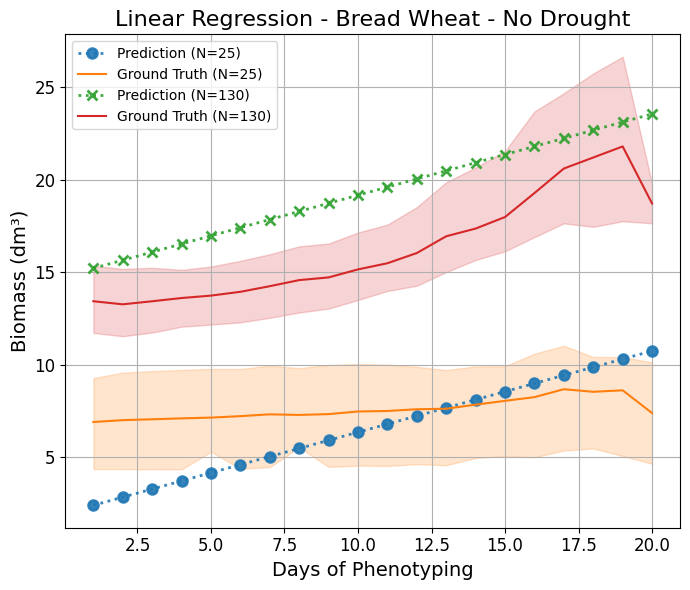

<Axes: title={'center': 'Linear Regression - Bread Wheat - No Drought'}, xlabel='Days of Phenotyping', ylabel='Biomass (dm³)'>

In [ ]:
# %% Test predictions over days for different nitrogen levels
test_species = "barley_2"
test_drought_stress = 1
test_days = np.arange(1, 21)
test_nitrogen_levels = [25, 130]

# Plot predictions for SVR model
plot_model_predictions_over_days(
    test_days,
    test_species,
    test_drought_stress,
    test_nitrogen_levels,
    preprocessor,
    y_scaler,
    best_model,
    model_name,
    df_loaded,
)

test_species = "bread_wheat"
test_drought_stress = 0
test_days = np.arange(1, 21)
test_nitrogen_levels = [25, 130]

# Plot predictions for SVR model
plot_model_predictions_over_days(
    test_days,
    test_species,
    test_drought_stress,
    test_nitrogen_levels,
    preprocessor,
    y_scaler,
    best_model,
    model_name,
    df_loaded,
)

In [ ]:


# Diagram settings
title_font_size = 12
axis_font_size = 12

plt.figure(figsize=(8, 5))
ax = df_loaded[
    (df_loaded['species'] == "barley_1") & (df_loaded['nitrogen_applied'] == 130) & (df_loaded['drought_stress'] == 1)
].plot.scatter(
    x='days_of_phenotyping',
    y='digital_biomass',
    alpha=0.7,
    ax=plt.gca()
)
ax.set_xlabel('Day of phenotyping', fontsize=axis_font_size)
ax.set_ylabel('Biomass [dm³]', fontsize=axis_font_size)
ax.set_title('Biomass vs. Day of phenotyping', fontsize=title_font_size)
plt.tight_layout()
plt.show()

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from ipywidgets import interact, Dropdown, IntSlider, FloatSlider

# Load your dataset (replace with your actual data)
# Example: df = pd.read_csv("crop_yield.csv")
# For demo, let's create a synthetic dataset resembling your description
np.random.seed(42)
days = np.random.randint(1, 100, size=500)  # days_of_phenotyping
# non-linear biomass (logistic growth: slow start, rapid middle, slow end) + modest noise
L = 60        # asymptotic max biomass
k = 0.12      # growth rate
x0 = 35       # inflection (middle) day
biomass = L / (1 + np.exp(-k * (days - x0))) + np.abs(np.random.normal(0, 3, size=days.shape))

# Function to add outliers
def add_outliers(df, n_outliers):
    if n_outliers > 0:
        outlier_indices = np.random.choice(df.index, n_outliers, replace=False)
        noise = np.random.normal(0, 30, n_outliers)
        new_vals = df.loc[outlier_indices, "digital_biomass"] + noise
        # ensure biomass can't go negative
        new_vals = np.maximum(new_vals, 0)
        df.loc[outlier_indices, "digital_biomass"] = new_vals
    return df

# Function to split and visualize data
def visualize_splits(split_type, n_outliers, poly_degree):
    # df = df_loaded[(df_loaded['species'] == "barley_1") & (df_loaded['nitrogen_applied'] == 130) & (df_loaded['drought_stress'] == 1)]
    df = pd.DataFrame({"days_of_phenotyping": days, "digital_biomass": biomass})

    # Add outliers
    df = add_outliers(df.copy(), n_outliers)

    # Split data
    if split_type == "random":
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    else:  # stratified split by binning days_of_phenotyping
        bins = pd.cut(df["days_of_phenotyping"], bins=10)
        train_df, test_df = train_test_split(df, test_size=0.2, stratify=bins, random_state=42)

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df["days_of_phenotyping"], bins=10, alpha=0.5, label="Whole dataset")
    plt.hist(train_df["days_of_phenotyping"], bins=10, alpha=0.5, label="Train set")
    plt.hist(test_df["days_of_phenotyping"], bins=10, alpha=0.5, label="Test set")
    plt.title(f"Distribution of Days (Split: {split_type})")
    plt.xlabel("Days of Phenotyping")
    plt.ylabel("Frequency")
    plt.legend()

    # Train model
    X_train = train_df[["days_of_phenotyping"]].values
    y_train = train_df["digital_biomass"].values
    X_test = test_df[["days_of_phenotyping"]].values
    y_test = test_df["digital_biomass"].values

    # Polynomial regression pipeline
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=poly_degree)),
        ("linear", LinearRegression())
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot model fit (predictions as a line)
    plt.subplot(1, 2, 2)
    plt.scatter(X_train, y_train, color="sandybrown", label="Train data", alpha=0.5)
    plt.scatter(X_test, y_test, color="green", label="Test data", alpha=0.5)

    # Create a dense range of x values to plot a smooth prediction curve
    X_range = np.linspace(df["days_of_phenotyping"].min(), df["days_of_phenotyping"].max(), 300).reshape(-1, 1)
    y_line = model.predict(X_range)

    plt.plot(X_range, y_line, color="red", label="Predicted (line)", linewidth=2)
    plt.title(f"Polynomial Regression (Degree={poly_degree})\nMSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    plt.xlabel("Days of Phenotyping")
    plt.ylabel("Digital Biomass")
    plt.ylim([-10, 100])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Interactive widgets
interact(
    visualize_splits,
    split_type=Dropdown(description="Split Type:", options=["random", "stratified"], value="random"),
    n_outliers=IntSlider(description="Number of Outliers:", min=0, max=200, step=5, value=0),
    poly_degree=IntSlider(description="Polynomial Degree:", min=1, max=5, step=1, value=1)
)
